<a href="https://colab.research.google.com/github/Nikkuchan/BleepBot/blob/main/QuartzNet_AudioRecogCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Install NVIDIA/QuartzNet
import os
from os.path import exists, join, basename, splitext
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

!pip -q install wget youtube-dl wget tensorboardX kaldi-io marshmallow num2words ruamel.yaml soundfile sox torch-stft unidecode
!pip install -q nemo-toolkit==0.9.0 nemo-asr==0.9.0 #--no-deps

if not exists('apex'):
  !git clone -q --depth 1 https://github.com/NVIDIA/apex
  !cd apex && pip install -q --no-cache-dir ./
  !pip install -q https://github.com/tugstugi/dl-colab-notebooks/archive/colab_utils.zip

from IPython.display import Audio, display, clear_output
import ipywidgets as widgets
import numpy as np
from scipy.io import wavfile
from dl_colab_notebooks.audio import record_audio, upload_audio

In [ ]:
if not exists('quartznet15x5_multidataset'):
  # download the pretrained weights
  !wget -nc -q --show-progress -O quartznet15x5.zip https://api.ngc.nvidia.com/v2/models/nvidia/multidataset_quartznet15x5/versions/1/zip
  !unzip quartznet15x5.zip && mkdir quartznet15x5_multidataset && mv Jasper* quartznet15x5.yaml quartznet15x5_multidataset

In [ ]:
# this code is copied and modified from the NVIDIA/NeMo repo.
import json
from ruamel.yaml import YAML
import nemo
import nemo_asr

WORK_DIR = "/content/quartznet15x5_multidataset"
MODEL_YAML = "/content/quartznet15x5_multidataset/quartznet15x5.yaml"
CHECKPOINT_ENCODER = "/content/quartznet15x5_multidataset/JasperEncoder-STEP-243800.pt"
CHECKPOINT_DECODER = "/content/quartznet15x5_multidataset/JasperDecoderForCTC-STEP-243800.pt"
# Set this to True to enable beam search decoder
ENABLE_NGRAM = False
# This is only necessary if ENABLE_NGRAM = True. Otherwise, set to empty string
LM_PATH = "<PATH_TO_KENLM_BINARY>"

# Read model YAML
yaml = YAML(typ="safe")
with open(MODEL_YAML) as f:
    jasper_model_definition = yaml.load(f)
labels = jasper_model_definition['labels']

# Instantiate necessary Neural Modules
# Note that data layer is missing from here
neural_factory = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
    backend=nemo.core.Backend.PyTorch)
data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor(factory=neural_factory)
jasper_encoder = nemo_asr.JasperEncoder(
    jasper=jasper_model_definition['JasperEncoder']['jasper'],
    activation=jasper_model_definition['JasperEncoder']['activation'],
    feat_in=jasper_model_definition['AudioToMelSpectrogramPreprocessor']['features'])
jasper_encoder.restore_from(CHECKPOINT_ENCODER, local_rank=0)
jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=1024,
    num_classes=len(labels))
jasper_decoder.restore_from(CHECKPOINT_DECODER, local_rank=0)
greedy_decoder = nemo_asr.GreedyCTCDecoder()

def wav_to_text(manifest, greedy=True):
    from ruamel.yaml import YAML
    yaml = YAML(typ="safe")
    with open(MODEL_YAML) as f:
        jasper_model_definition = yaml.load(f)
    labels = jasper_model_definition['labels']

    # Instantiate necessary neural modules
    data_layer = nemo_asr.AudioToTextDataLayer(
        shuffle=False,
        manifest_filepath=manifest,
        labels=labels, batch_size=1)

    # Define inference DAG
    audio_signal, audio_signal_len, _, _ = data_layer()
    processed_signal, processed_signal_len = data_preprocessor(
        input_signal=audio_signal,
        length=audio_signal_len)
    encoded, encoded_len = jasper_encoder(audio_signal=processed_signal,
                                          length=processed_signal_len)
    log_probs = jasper_decoder(encoder_output=encoded)
    predictions = greedy_decoder(log_probs=log_probs)

    if ENABLE_NGRAM:
        print('Running with beam search')
        beam_predictions = beam_search_with_lm(
            log_probs=log_probs, log_probs_length=encoded_len)
        eval_tensors = [beam_predictions]

    if greedy:
        eval_tensors = [predictions]

    tensors = neural_factory.infer(tensors=eval_tensors)
    if greedy:
        from nemo_asr.helpers import post_process_predictions
        prediction = post_process_predictions(tensors[0], labels)
    else:
        prediction = tensors[0][0][0][0][1]
    return prediction

def create_manifest(file_path):
    # create manifest
    manifest = dict()
    manifest['audio_filepath'] = file_path
    manifest['duration'] = 18000
    manifest['text'] = 'todo'
    with open(file_path+".json", 'w') as fout:
        fout.write(json.dumps(manifest))
    return file_path+".json"

2022-05-30 14:32:18,970 - INFO - PADDING: 16
2022-05-30 14:32:18,970 - INFO - PADDING: 16


STFT using torch


#**Keyword Recognition using CNN**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/mini_speech_commands.zip -d path_to_directory

In [ ]:
DATASET_PATH = '/content/path_to_directory/mini_speech_commands'

In [ ]:
# DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="https://drive.google.com/file/d/1xNWGMVmjhokShI22MIeeN10UshrrjBQS/view?usp=sharing",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['bobo' 'fuck' 'gago' 'tanga' 'putangina']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 75
Number of examples per label: 15
Example file tensor: tf.Tensor(b'/content/path_to_directory/mini_speech_commands/tanga/tanga3.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [ ]:
train_files = filenames[:59] #6400 
val_files = filenames[59: 59 + 8] #6400: 6400 + 800
test_files = filenames[-8:] #-800

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 59
Validation set size 8
Test set size 8


Read the audio files and their labels

In [ ]:
test_file = tf.io.read_file(DATASET_PATH+'/gago/Gg7.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

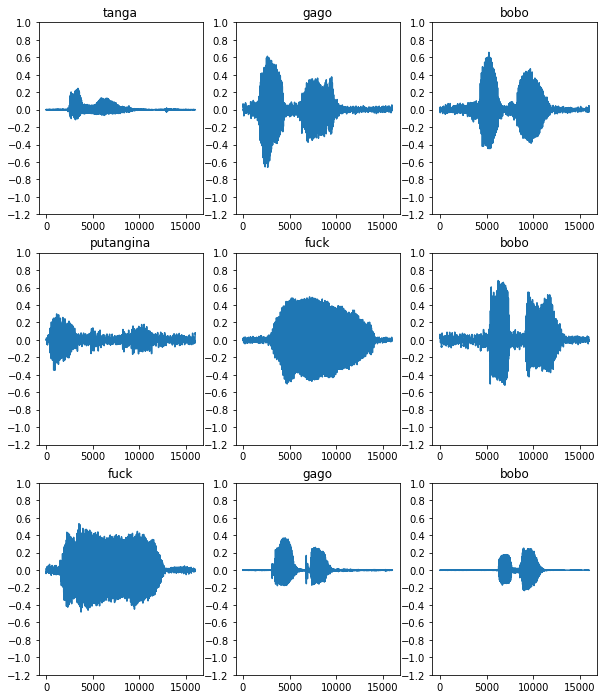

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

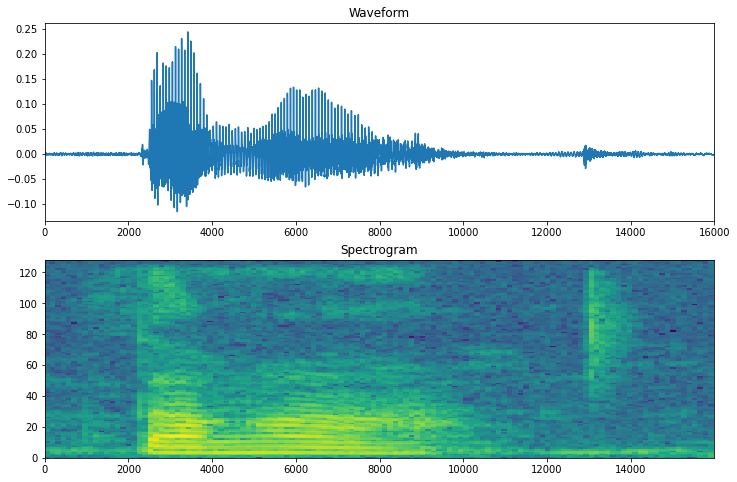

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

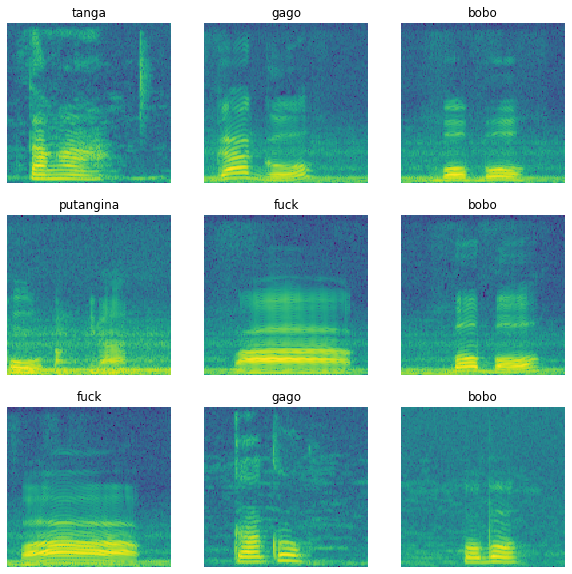

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

##**train the model**

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.6380 - accuracy: 0.1695 - val_loss: 1.4753 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 1.4239 - accuracy: 0.4407 - val_loss: 1.3036 - val_accuracy: 0.6250
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 1.2421 - accuracy: 0.5254 - val_loss: 1.0718 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 1.0300 - accuracy: 0.6610 - val_loss: 0.8689 - val_accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.8472 - accuracy: 0.7119 - val_loss: 0.6894 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.8121 - accuracy: 0.7119 - val_loss: 0.5573 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.7316 - accuracy: 0.7458 - val_loss: 0.4785 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=============

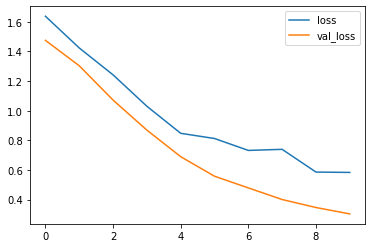

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

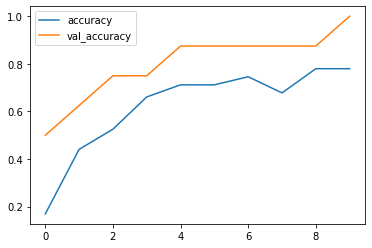

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Evaluate 

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "bobo". How well does the model perform?

In [ ]:
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 

SAMPLE_RATE = 16000
record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =   2#@param {type:"number", min:1, max:10, step:1}

def _recognize(audio):
  display(Audio(audio, rate=SAMPLE_RATE, autoplay=True))
  wavfile.write('test.wav', SAMPLE_RATE, (32767*audio).astype(np.int16))

  print('\n')
  transcription = wav_to_text(create_manifest('test.wav'))
  # print('\n\n')
  print(transcription)


def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
  _recognize(audio)
def _upload_audio(b):
  clear_output()
  audio = upload_audio(sample_rate=SAMPLE_RATE)
  _recognize(audio)

if record_or_upload == "Record":
  button = widgets.Button(description="Record Profanity")
  button.on_click(_record_audio)
  display(button)
else:
  _upload_audio("")


Starting recording for 2 seconds...


<IPython.core.display.Javascript object>

Finished recording!


2022-05-30 15:03:00,756 - INFO - Dataset loaded with 5.00 hours. Filtered 0.00 hours.
2022-05-30 15:03:00,756 - INFO - Dataset loaded with 5.00 hours. Filtered 0.00 hours.
2022-05-30 15:03:00,761 - INFO - Evaluating batch 0 out of 1
2022-05-30 15:03:00,761 - INFO - Evaluating batch 0 out of 1




['gar go']


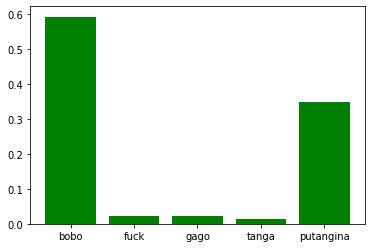

In [ ]:
sample_file = '/content/test.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]),color = 'green')
  
  # plt.title(f'Predictions')
  plt.show()